<a href="https://colab.research.google.com/github/Dimildizio/DArc_course/blob/main/EDA/PimaKaggle/Pima_indians_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima indians diabetes kaggle dataset

### import libs

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

In [21]:
%matplotlib inline

### download dataset

In [6]:
%%capture
!wget -O pima.csv https://raw.githubusercontent.com/Dimildizio/DArc_course/main/EDA/PimaKaggle/pima-indians-diabetes.csv

In [66]:
columns = ['pregnancies','glucose', 'blood_presure', 'skin_thickness', 'insulin', 'BMI', 'Pedigree', 'Age', 'Result']
data = pd.read_csv('pima.csv', names = columns)
data.head()

,pregnancies,glucose,blood_presure,skin_thickness,insulin,BMI,Pedigree,Age,Result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### Check the size of the dataset

In [67]:
data.shape

(768, 9)

### Check for NaNs and data types

In [68]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnancies     768 non-null    int64  
 1   glucose         768 non-null    int64  
 2   blood_presure   768 non-null    int64  
 3   skin_thickness  768 non-null    int64  
 4   insulin         768 non-null    int64  
 5   BMI             768 non-null    float64
 6   Pedigree        768 non-null    float64
 7   Age             768 non-null    int64  
 8   Result          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### Convert float\int 64 to 32 for faster operatinos

In [69]:
for col in data.columns:
  if data[col].dtype == 'float64':
    data[col] = data[col].astype('float32')

  elif data[col].dtype == 'int64':
    data[col] = data[col].astype('int32')

### Get statistics by columns

In [19]:
pd.set_option('display.precision', 3)
data.describe()

,pregnancies,glucose,blood_presure,skin_thickness,insulin,BMI,Pedigree,Age,Result
count,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000,768.000
mean,3.845,120.895,69.105,20.536,79.799,31.993,0.472,33.241,0.349
std,3.370,31.973,19.356,15.952,115.244,7.884,0.331,11.760,0.477
min,0.000,0.000,0.000,0.000,0.000,0.000,0.078,21.000,0.000
25%,1.000,99.000,62.000,0.000,0.000,27.300,0.244,24.000,0.000
50%,3.000,117.000,72.000,23.000,30.500,32.000,0.372,29.000,0.000
75%,6.000,140.250,80.000,32.000,127.250,36.600,0.626,41.000,1.000
max,17.000,199.000,122.000,99.000,846.000,67.100,2.420,81.000,1.000


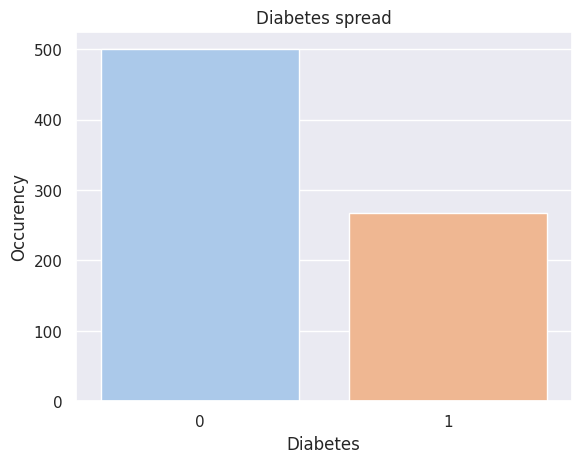

In [44]:
sns.set(style="darkgrid")
sns.set_palette('pastel')
sns.countplot(data=data, x='Result')

plt.title('Diabetes spread')
plt.xlabel('Diabetes')
plt.ylabel('Occurency')
plt.show()

Not ideal distibution, so we'll have to address this issue later, possibly by adding sythetic rows for.

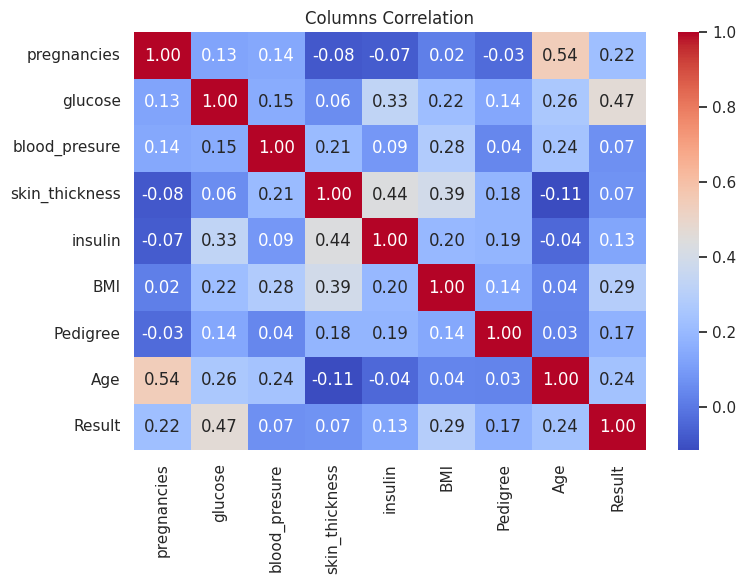

In [70]:
plt.figure(figsize=(8,6))

corr_matrix = data.corr()
sns.heatmap(data=corr_matrix, annot=True, fmt = '.2f', cmap='coolwarm')
plt.title('Columns Correlation')
plt.tight_layout()

Clearly a very "combed" dataset. No NaNs, no high correlation